**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Procesamiento del Lenguaje Natural** 

***
Datos del alumno (Nombre y Apellidos): Selene González Curbelo

Fecha: 16/12/2024
***

<span style="font-size: 20pt; font-weight: bold; color: #0098cd;">Trabajo: Named-Entity Recognition</span>

**Objetivos** 

Con esta actividad se tratará de que el alumno se familiarice con el manejo de la librería spacy, así como con los conceptos básicos de manejo de las técnicas NER

**Descripción**

En esta actividad debes procesar de forma automática un texto en lenguaje natural para detectar características básicas en el mismo, y para identificar y etiquetar las ocurrencias de conceptos como localización, moneda, empresas, etc.

En la primera parte del ejercicio se proporciona un código fuente a través del cual se lee un archivo de texto y se realiza un preprocesado del mismo. En esta parte el alumno tan sólo debe ejecutar y entender el código proporcionado.

En la segunda parte del ejercicio se plantean una serie de preguntas que deben ser respondidas por el alumno. Cada pregunta deberá responderse con un fragmento de código fuente que esté acompañado de la explicación correspondiente. Para elaborar el código solicitado, el alumno deberá visitar la documentación de la librería spacy, cuyos enlaces se proporcionarán donde corresponda.

# Parte 1: carga y preprocesamiento del texto a analizar

Observa las diferentes librerías que se están importando.

In [219]:
#!python -m spacy download es_core_news_md
import pathlib
import spacy
import pandas as pd
from spacy import displacy
import csv
import es_core_news_md
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  
from collections import Counter
import spacy
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Carga del Modelo

El siguiente código simplemente carga y preprocesa el texto. Para ello, lo primero que hace es cargar un modelo de lenguaje previamente entrenado. En este caso, se utiliza <i>es_core_news_md</i>: 

https://spacy.io/models/es#es_core_news_md


In [220]:
nlp = es_core_news_md.load()

El modelo <i>es_core_news_md</i>, es de tamaño medio, lo que significa que busca un equilibrio entre precisión y rendimineto. Al ser más pequeño que <i>es_core_news_lg</i>, es menos pesado en términos de recursos computacionales, lo cual es importante cuando se trabaja en grandes volúmenes de datos. Además, con respecto a otros modelos más ligeros como es el caso de <i>es_core_news_sm</i>, mantienen una buena capacidad de análisis semántico gracias a los vectores de palabras. Además, el modelo tiene componentes como tokenización, morfología, lematización y reconocimiento de entidades ya integrados en el pipeline. También, está diseñado específicamente para textos en castellano, como los datos observados en el <i>CSV</i> a analizar.

# Carga de Datos

In [221]:
filename = "./02Dataset_sin_procesar.csv"

data = pd.read_csv(
    filename,
    delimiter=';', 
    encoding='utf-8', 
    low_memory=False, 
    encoding_errors='replace', 
    decimal=",",
    skip_blank_lines=True,
)

El fragmento de código anterior se utiliza para cargar un archivo <i>CSV</i> en un <i>DataFrame</i> de pandas, especificando varios parámetros para manejar diferentes aspectos del archivo, como es el caso de la ruta del archivo, la codificación de caracteres y la manera en la que se deben de tratar las líneas vacías.

# Limpieza de Datos

Antes de analizar los datos, se ha realizado una limpieza exhaustiva:

- **Eliminación de duplicados**: Se eliminaron las filas duplicadas en todo el conjunto y específicamente en la columna "CONTENIDO A ANALIZAR" para asegurar que los datos sean únicos.
- **Eliminación de columnas irrelevantes**: Se eliminaron las columnas con nombres como "Unnamed" por ser vacías o irrelevantes.
- **Eliminación de valores nulos**: Se eliminaron las filas con valores nulos en "CONTENIDO A ANALIZAR", "TIPO DE MENSAJE" e "INTENSIDAD", asegurando que estas columnas clave estén completas para un análisis correcto.

In [222]:
data = data.drop_duplicates()
data = data.drop_duplicates(subset=['CONTENIDO A ANALIZAR'])
data = data.loc[:, ~data.columns.str.contains('^Unnamed', na=False)]
data = data.dropna(subset=['CONTENIDO A ANALIZAR', 'TIPO DE MENSAJE', 'INTENSIDAD'])
data['INTENSIDAD'] = pd.to_numeric(data['INTENSIDAD'], errors='coerce')

# Muestreo Aleatorio de Datos

Para poder manejar un volumen de datos adecuado de manera eficiente, se ha optado por usar una muestra aleatoria de 10000 filas del <i>DataFrame</i> original. Esto se debe a las limitaciones de RAM que causan que el kernel se quede sin memoria tanto en un entorno local como en Google Colab. 

In [223]:
x=10000
data = data.sample(n=x, random_state=42)

# Verificación de Carga de Datos

Al ejecutar la línea siguiente, se comprueba que los valores se han cargado correctamente y que las columnas vacías o irrelevantes, como las que llevan nombres "Unnamed", han sido eliminadas. 

In [224]:
data.head()

,MEDIO,SOPORTE,URL,TIPO DE MENSAJE,CONTENIDO A ANALIZAR,INTENSIDAD,TIPO DE ODIO,TONO HUMORISTICO,MODIFICADOR
380731,EL MUNDO,WEB,https://www.elmundo.es/internacional/2021/01/0...,COMENTARIO,empezamos a despedirnos de juanito.,0.0,NaN,NaN,NaN
425774,ABC,WEB,https://www.abc.es/internacional/abci-talibane...,NOTICIA,las mujeres trabajadoras en afganistán deben q...,0.0,NaN,NaN,NaN
494599,EL MUNDO,WEB,https://www.elmundo.es/madrid/2021/01/10/5ffa1...,COMENTARIO,@vigia_de_occidente #54 la epidemia solo provo...,0.0,NaN,NaN,NaN
175824,EL PAÍS,TWITTER,https://twitter.com/el_pais/status/13482906008...,COMENTARIO,las pernoctaciones en establecimientos hoteler...,0.0,NaN,NaN,NaN
29481,EL MUNDO,WEB,https://www.elmundo.es/cataluna/2021/01/03/5ff...,COMENTARIO,@maneras_de_vivir #64 en el chalé también,0.0,NaN,NaN,NaN


Además, para confirmar que los valores de "CONTENIDO A ANALIZAR" son únicos y verificar que coinciden con el conteo de entradas (count), puedes utilizar data.describe() para validar esta unicidad.

In [225]:
data['CONTENIDO A ANALIZAR'].describe()

count                                   10000
unique                                  10000
top       empezamos a despedirnos de juanito.
freq                                        1
Name: CONTENIDO A ANALIZAR, dtype: object

# Procesamiento

Este fragmento de código procesa y almacena los documentos una sola vez utilizando spaCy, para evitar tener que procesar los mismos documentos repetidamente a lo largo del proyecto. Esto es útil para no utilizar más procesamiento NLP en el futuro. Al procesar los textos una sola vez y almacenar los resultados, este enfoque minimiza las operaciones redundantes y optimiza el rendimiento general.

In [237]:
comments = data[data['TIPO DE MENSAJE'] == 'COMENTARIO'][['CONTENIDO A ANALIZAR', 'INTENSIDAD']].dropna()

docs_ = list(nlp.pipe(comments['CONTENIDO A ANALIZAR'], batch_size=500, n_process=1))

comments['docs'] = docs_

docs_processed_filtered = []
for doc in docs_:
    filtered_tokens = []
    for token in doc:
        if token.is_alpha:
            if token.ent_type_ != "":
                filtered_tokens.append(token.text)
            else:
                filtered_tokens.append(token.text.lower())   
    docs_processed_filtered.append(filtered_tokens)
    
data['docs_processed'] = pd.Series(docs_processed_filtered)
comments['docs_processed'] = pd.Series(docs_processed_filtered)

# Añadir columnas para comentarios de odio y sin odio
comments['hate'] = comments['INTENSIDAD'] != 0.0
comments['no_hate'] = comments['INTENSIDAD'] == 0.0

# Llenar las nuevas columnas con los documentos procesados correspondientes
comments['hate_docs_processed'] = comments.apply(lambda x: x['docs_processed'] if x['hate'] else None, axis=1)
comments['no_hate_docs_processed'] = comments.apply(lambda x: x['docs_processed'] if x['no_hate'] else None, axis=1)


Este código detecta entidades en los comentarios y almacena los resultados en nuevas columnas del DataFrame.

In [227]:
entities_of_interest = ['PER', 'GPE', 'LOC', 'ORG', 'MONEY', 'DATE']

contains_ner = []
contains_per = []

for doc in docs_:
    contains_ner_value = any(ent.label_ in entities_of_interest for ent in doc.ents)

    contains_per_value = any(
        ent.label_ == 'PER' and all(token.pos_ == 'PROPN' for token in ent)
        for ent in doc.ents
    )

    contains_ner.append(contains_ner_value)
    contains_per.append(contains_per_value)

data['contains_ner'] = pd.Series(contains_ner)
data['contains_per'] = pd.Series(contains_per)
comments['contains_ner'] = pd.Series(contains_ner)
comments['contains_per'] = pd.Series(contains_per)

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 1.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuántos registros contiene el corpus?</span>

In [228]:
# Incluye aquí el código generado para poder responder a tu pregunta
num_records = data.shape[0]
print(f"El conjunto de datos contiene {num_records} registros.")

El conjunto de datos contiene 10000 registros.


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Se utiliza data.shape[0], que devuelve una tupla con el número de filas y columnas del DataFrame. Al acceder a la posición [0] de la tupla, obtenemos el número de filas.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 2.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuántas palabras totales hay en los comentarios del corpus?</span>

In [229]:
# Incluye aquí el código generado para poder responder a tu pregunta
total_words = sum(len(doc) for doc in docs_processed_filtered)
print(f"Total palabras: {total_words}")

Total palabras: 295038


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Se itera por cada documento y calcula la longitud (número de palabras) de cada documento. Luego se suman estas longitudes para obtener el total de palabras.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 3.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuál el número promedio de palabras en cada comentario?</span>

In [230]:
# Incluye aquí el código generado para poder responder a tu pregunta
num_comments = len(comments)
num_average_words = total_words / num_comments
num_average_words = round(num_average_words, 2)
print(f"El promedio de palabras por comentario es de {num_average_words}.")

El promedio de palabras por comentario es de 48.94.


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
El número promedio de palabras por comentario se calcula dividiendo el número total de palabras en el corpus (total_words) por el número total de comentarios (num_comments). Este cálculo se redondea a dos decimales para mayor claridad.


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 4.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál el número promedio de palabras en los comentarios de cada grupo?</span>

In [ ]:
# Incluye aquí el código generado para poder responder a tu pregunta
hate_comments = comments[comments['INTENSIDAD'] != 0.0].dropna(subset=['docs_processed'])
no_hate_comments = comments[comments['INTENSIDAD'] == 0.0].dropna(subset=['docs_processed'])

hate_docs = hate_comments['docs_processed'].tolist()
no_hate_docs = no_hate_comments['docs_processed'].tolist()

num_hate_words = sum(len(doc) for doc in hate_docs)
num_no_hate_words = sum(len(doc) for doc in no_hate_docs)

num_hate_comments = len(hate_docs)
num_no_hate_comments = len(no_hate_docs)

avg_hate_words = num_hate_words / num_hate_comments if num_hate_comments > 0 else 0
avg_no_hate_words = num_no_hate_words / num_no_hate_comments if num_no_hate_comments > 0 else 0

print(f"Promedio de palabras en comentarios de odio: {avg_hate_words:.2f}")
print(f"Promedio de palabras en comentarios sin odio: {avg_no_hate_words:.2f}")

Promedio de palabras en comentarios de odio: 40.22
Promedio de palabras en comentarios sin odio: 24.53


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Este código separa los comentarios según su intensidad en "odio" y "no odio". Luego, calcula la cantidad total de palabras y el número de comentarios en cada categoría. Con estos datos, obtiene el promedio de palabras por comentario para ambos tipo.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 5.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el número promedio de oraciones en los comentarios de cada grupo?</span>

In [215]:
# Incluye aquí el código generado para poder responder a tu pregunta
num_hate_sentences = sum(len(list(doc.sents)) for doc in hate_comments['docs'])
num_no_hate_sentences = sum(len(list(doc.sents)) for doc in no_hate_comments['docs'])

num_average_hate_sentences = num_hate_sentences / len(hate_docs) if len(hate_docs) > 0 else 0
num_average_no_hate_sentences = num_no_hate_sentences / len(no_hate_docs) if len(no_hate_docs) > 0 else 0

print(f"Promedio de oraciones por comentario de odio: {num_average_hate_sentences:.2f}")
print(f"Promedio de oraciones por comentario sin odio: {num_average_no_hate_sentences:.2f}")

Promedio de oraciones por comentario de odio: 1.89
Promedio de oraciones por comentario sin odio: 1.79


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Este código calcula el promedio de oraciones por comentario en dos categorías: odio y no odio. Primero, cuenta el número total de oraciones en cada categoría. Luego, calcula el promedio de oraciones por comentario dividiendo el número total de oraciones entre el número de comentarios en cada categoría.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 6.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de comentarios que contienen entidades NER en cada grupo?</span>

In [216]:
# Incluye aquí el código generado para poder responder a tu pregunta
hate_comments_with_ner = hate_comments['contains_ner'].sum()
hate_percentage_with_ner = (hate_comments_with_ner / len(hate_comments)) * 100 if len(hate_comments) > 0 else 0

no_hate_comments_with_ner = no_hate_comments['contains_ner'].sum()
no_hate_percentage_with_ner = (no_hate_comments_with_ner / len(no_hate_comments)) * 100 if len(no_hate_comments) > 0 else 0

print(f"Porcentaje de comentarios con entidades NER en comentarios de odio: {hate_percentage_with_ner:.2f}%")
print(f"Porcentaje de comentarios con entidades NER en comentarios sin odio: {no_hate_percentage_with_ner:.2f}%")

Porcentaje de comentarios con entidades NER en comentarios de odio: 55.56%
Porcentaje de comentarios con entidades NER en comentarios sin odio: 34.91%


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Primero, cuenta los comentarios de cada categoría que contienen entidades NER. Luego, calcula el porcentaje de estos comentarios respecto al total en cada categoría. 

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 7.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de comentarios que contienen entidades NER de tipo PERSON en cada grupo?</span>

In [217]:
# Incluye aquí el código generado para poder responder a tu pregunta
hate_comments_with_per = hate_comments['contains_per'].sum()
no_hate_comments_with_per = no_hate_comments['contains_per'].sum()

hate_percentage_with_per = (hate_comments_with_per / len(hate_comments)) * 100
no_hate_percentage_with_per = (no_hate_comments_with_per / len(no_hate_comments)) * 100

print(f"Porcentaje de comentarios con la entidad 'PER' en comentarios de odio: {hate_percentage_with_per:.2f}%")
print(f"Porcentaje de comentarios con la entidad 'PER' en comentarios sin odio: {no_hate_percentage_with_per:.2f}%")

Porcentaje de comentarios con la entidad 'PER' en comentarios de odio: 11.11%
Porcentaje de comentarios con la entidad 'PER' en comentarios sin odio: 8.49%


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Cuenta los comentarios con la entidad "PER" en cada categoría. Luego, calcula el porcentaje de estos comentarios respecto al total de cada categoría.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 8.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de palabras en cada combinación posible de género y número (p.ej. masculino singular) en cada grupo?</span>

In [245]:
# Incluye aquí el código generado para poder responder a tu pregunta
hate_morph_counts_stop = {'Masc_Sg': 0, 'Fem_Sg': 0, 'Masc_Pl': 0, 'Fem_Pl': 0}
no_hate_morph_counts_stop = {'Masc_Sg': 0, 'Fem_Sg': 0, 'Masc_Pl': 0, 'Fem_Pl': 0}

gender_map = {"Masc": "Masc", "Fem": "Fem"}
number_map = {"Sing": "Sg", "Plur": "Pl"}

def update_morph_counts(docs, morph_counts):
    """ 
    Actualiza los conteos de formas morfológicas (género y número) en una lista de documentos. 
    Args: 
        docs (list): Lista de documentos procesados por spaCy. 
        morph_counts (dict): Diccionario para almacenar los conteos de formas morfológicas. 
    """
    for doc in docs:
        for token in doc:
            if token.is_alpha and not token.is_stop:  
                gender = token.morph.get("Gender")
                number = token.morph.get("Number")
                if gender and number: 
                    gender_key = gender_map.get(gender[0], "")
                    number_key = number_map.get(number[0], "")
                    if gender_key and number_key:
                        key = f"{gender_key}_{number_key}"
                        if key in morph_counts:
                            morph_counts[key] += 1


update_morph_counts(hate_comments['docs'], hate_morph_counts_stop)
update_morph_counts(no_hate_comments['docs'], no_hate_morph_counts_stop)

total_hate_words_stop = sum(hate_morph_counts_stop.values())
total_no_hate_words_stop = sum(no_hate_morph_counts_stop.values())

hate_morph_percentages_stop = {k: (v / total_hate_words_stop) * 100 for k, v in hate_morph_counts_stop.items()}
no_hate_morph_percentages_stop = {k: (v / total_no_hate_words_stop) * 100 for k, v in no_hate_morph_counts_stop.items()}

print("Porcentajes de género y número en comentarios de odio:")
for key, value in hate_morph_percentages_stop.items():
    print(f"{key}: {value:.2f}%")

print("\nPorcentajes de género y número en comentarios sin odio:")
for key, value in no_hate_morph_percentages_stop.items():
    print(f"{key}: {value:.2f}%")

Porcentajes de género y número en comentarios de odio:
Masc_Sg: 43.66%
Fem_Sg: 39.44%
Masc_Pl: 11.27%
Fem_Pl: 5.63%

Porcentajes de género y número en comentarios sin odio:
Masc_Sg: 38.55%
Fem_Sg: 35.05%
Masc_Pl: 14.02%
Fem_Pl: 12.38%


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Inicializa diccionarios para contar los tokens según género y número. La función update_morph_counts procesa cada documento, verificando que los tokens sean alfabéticos y no sean palabras de parada antes de contar su género y número. Luego, actualiza los conteos en los diccionarios correspondientes. Posteriormente, calcula los porcentajes de cada forma morfológica en relación con el total de palabras filtradas para ambos tipos de comentarios. Además, se excluyen las stopwords para enfocarse en las palabras más significativas y relevantes.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 9.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio), indica cuántas entidades de cada tipo posible se reconocen en cada uno de los grupos</span>

In [252]:
# Incluye aquí el código generado para poder responder a tu pregunta
hate_entity_counts = defaultdict(int)
no_hate_entity_counts = defaultdict(int)

for doc in hate_comments['docs']:
    for ent in doc.ents:
        hate_entity_counts[ent.label_] += 1

for doc in no_hate_comments['docs']:
    for ent in doc.ents:
        no_hate_entity_counts[ent.label_] += 1

print("Entidades en comentarios de odio")
for label, count in hate_entity_counts.items():
    print(f"{label}: {count}")
print("Entidades en comentarios de no odio")
for label, count in no_hate_entity_counts.items():
    print(f"{label}: {count}")

Entidades en comentarios de odio
MISC: 1
PER: 5
ORG: 2
LOC: 1
Entidades en comentarios de no odio
MISC: 12
LOC: 13
PER: 17
ORG: 7


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Inicializa diccionarios para almacenar estos conteos. Luego, itera sobre los documentos de cada categoría, actualizando los conteos según las entidades encontradas.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 10.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio), extrae y muestra los 100 lemas más repetidos en los comentarios de cada grupo</span>

In [248]:
def count_lemas(docs):
    """ 
    Cuenta los lemas en una lista de documentos, incluyendo entidades reconocidas, 
    excluyendo palabras de parada y considerando solo tokens alfabéticos. 
    Args: 
        docs (list): Lista de documentos procesados por spaCy. 
    Returns: 
        Counter: Un contador con los lemas y sus frecuencias. 
    """
    lemma_count = Counter()  
    for doc in docs:        
        tokens_in_entities = set()
        for ent in doc.ents:
            entity_text = ent.text
            lemma_count[entity_text] += 1  #
            tokens_in_entities.update(token.i for token in ent)
        for token in doc:
            if token.i not in tokens_in_entities:  
                if token.is_alpha and not token.is_stop:  
                    lemma = token.lemma_.lower()
                    if lemma in lemma_count:
                        lemma_count[lemma] += 1
                    else:
                        lemma_count[lemma] = 1
    return lemma_count

def display_top_100_lemmas(lemma_count):
    """ 
    Muestra los 100 lemas más frecuentes en un contador de lemas. 
    Args: 
        lemma_count (Counter): Un contador con los lemas y sus frecuencias. 
    """
    sorted_lemmas = lemma_count.most_common(100)
    
    print("Los 100 lemas más repetidos:")
    for lemma, count in sorted_lemmas:
        print(f"{lemma}: {count}")

hate_lemas_count = count_lemas(hate_comments['docs'])  
no_hate_lemas_count = count_lemas(no_hate_comments['docs'])  

print("Repetición de lemas comentarios de odio:")
display_top_100_lemmas(hate_lemas_count)

print("\nRepetición de lemas comentarios sin odio:")
display_top_100_lemmas(no_hate_lemas_count)

Repetición de lemas comentarios de odio:
Los 100 lemas más repetidos:
pp: 2
responsable: 2
payaso: 2
máster: 2
sánchez: 2
gente: 2
iglesia: 1
dirigir: 1
comunista: 1
tengamos: 1
obispo: 1
cobardón: 1
céntimo: 1
misa: 1
celebrar: 1
cura: 1
conocer: 1
vida: 1
pie: 1
coger: 1
vergüenza: 1
fascista: 1
tc: 1
fernando suárez: 1
ramos lópez: 1
i. gonzález: 1
cifuentes: 1
difunto: 1
álvarez: 1
conde: 1
actuar: 1
cátedra: 1
derecho: 1
constitucional: 1
conventículo: 1
master: 1
bendición: 1
académico: 1
administrativo: 1
rector: 1
concernido: 1
amar: 1
president: 1
cam: 1
gallardón: 1
investigada: 1
aguirre: 1
acusado: 1
corriente: 1
ayuso: 1
cuarto: 1
siglo: 1
contemplar: 1
gracias: 1
mayoría: 1
absoluto: 1
obtenido: 1
votante: 1
finalmente: 1
condenado: 1
sentencia: 1
firme: 1
nº: 1
an: 1
confirmado: 1
ts: 1
desaguisado: 1
desencadenar: 1
elegir: 1
aravaca eeuu: 1
preguntárselo: 1
fracasado: 1
medio: 1
carrera: 1
mes: 1
presencial: 1
clase: 1
nivel: 1
corrupción: 1
basura: 1
periodístico: 1
p

<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
Este código cuenta y muestra los 100 lemas más comunes en comentarios de odio y sin odio. La función count_lemas() recorre cada documento, cuenta los lemas (formas base de las palabras). También omite stopwords y solo procesa tokens alfabéticos. La función display_top_100_lemmas() ordena y muestra los 100 lemas más frecuentes. Luego, el código calcula los lemas para comentarios de odio y sin odio. 

Además, el código permite términos compuestos como es el caso de "presidente de Madrid", por ello, se procesan primero las entidades para asegurar que términos específicos no se dividan incorrectamente. Aunque el código no cuenta con un vocabulario personalizado para jerga específica o términos en otros idiomas, puede resultar en una identificación menos precisa de algunos lemas o entidades en diferentes contextos lingüísticos.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 11.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Es posible utilizar alguna de las características extraídas en las preguntas anteriores para determinar si un mensaje contiene odio? Justifica tu respuesta con el análisis estadístico que consideres necesario.</span>

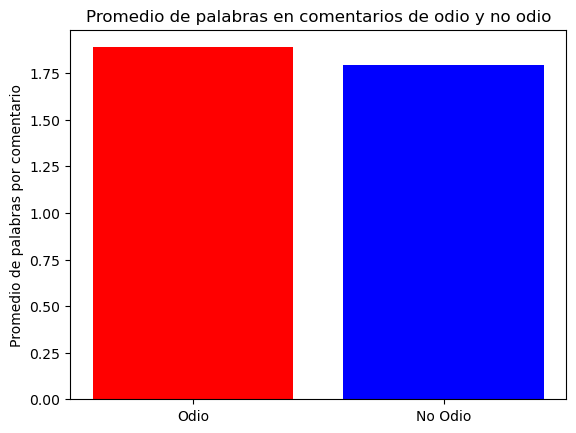

In [251]:
average_words = [num_average_hate_sentences, num_average_no_hate_sentences]
categories = ['Odio', 'No Odio']

plt.bar(categories, average_words, color=['red', 'blue'])
plt.ylabel('Promedio de palabras por comentario')
plt.title('Promedio de palabras en comentarios de odio y no odio')
plt.show()

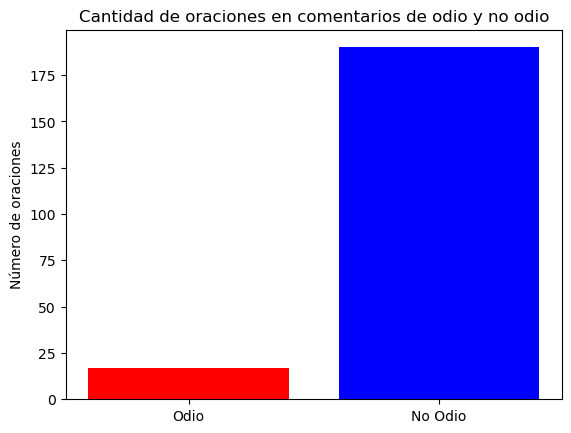

In [253]:
categories = ['Odio', 'No Odio']
num_sentences = [num_hate_sentences, num_no_hate_sentences]

# Crear gráfico de barras
plt.bar(categories, num_sentences, color=['red', 'blue'])
plt.ylabel('Número de oraciones')
plt.title('Cantidad de oraciones en comentarios de odio y no odio')
plt.show()

Además, aunque no hay mucha diferencia, hay una gran disparidad entre la cantidad de datos de no odio (que predominan) sobre los de odio. Esto es un factor importante a considerar, ya que el desbalance de datos puede afectar los resultados y la precisión de cualquier modelo de clasificación que se desarrolle. 

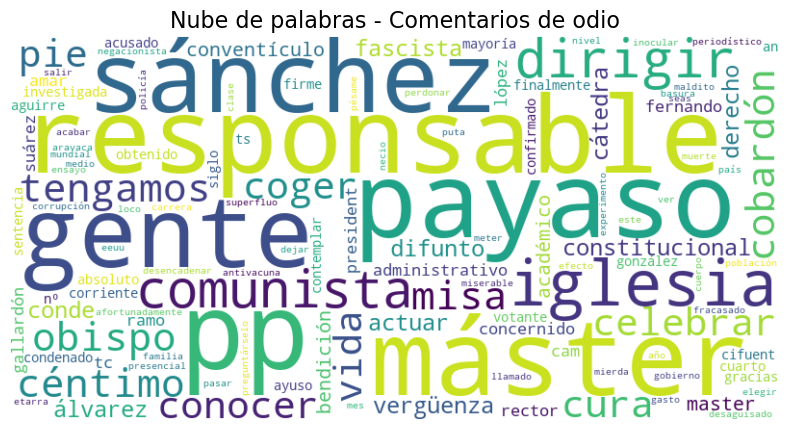

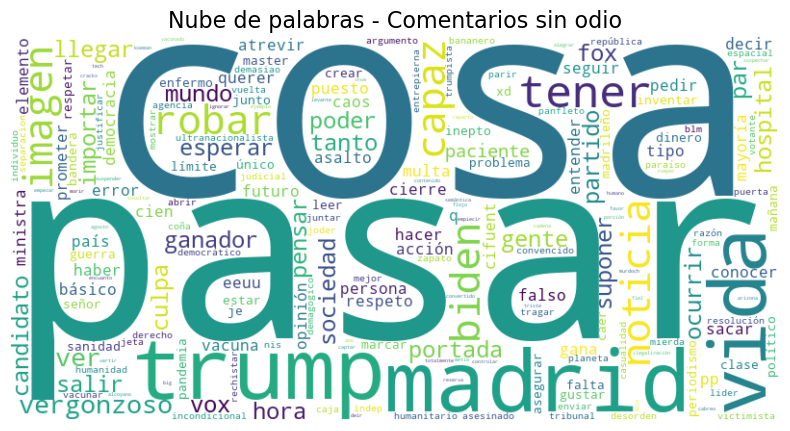

In [ ]:
def count_lemmas(documents):
    lemma_count = Counter() 
    for doc in documents:
        for token in doc:
            if token.is_alpha and not token.is_stop:  
                lemma_count[token.lemma_] += 1
    return lemma_count

hate_lemmas_count = count_lemmas(hate_comments['docs'])
no_hate_lemmas_count = count_lemmas(no_hate_comments['docs'])

def create_wordcloud(lemma_count, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(lemma_count)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

create_wordcloud(hate_lemmas_count, "Nube de palabras - Comentarios de odio")
create_wordcloud(no_hate_lemmas_count, "Nube de palabras - Comentarios sin odio")


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

Con los valores que se han obtenido, se puede realizar un estudio para identificar características que distinguen comentarios de odio de aquellos que no lo son. 
- Los comentarios de odio tienen un promedio de palabras y oraciones ligeramente superior a los comentarios sin odio. Esto podría indicar que los comentarios de odio tienden a ser más extensos y detallados.
- La mayor proporción de comentarios de odio contiene entidades reconocidas (55.56%) en comparación con los comentarios sin odio (34.91%). Esto sugiere que los comentarios de odio a menudo mencionan nombres propios, organizaciones, y lugares más frecuentemente.
- Hay una ligera diferencia en el porcentaje de comentarios que mencionan entidades 'PER' entre los comentarios de odio (11.11%) y los comentarios sin odio (8.49%). Esto podría implicar que los comentarios de odio tienden a mencionar a personas específicas con más frecuencia.
- Observando las variaciones en la distribución de género y número entre comentarios de odio y sin odio, se pueden notar patrones significativos. La mayor proporción de palabras masculinas singulares en comentarios de odio (43.66% frente a 38.55%) y la prevalencia de palabras plurales en comentarios sin odio sugiere diferencias estructurales y lingüísticas en estos tipos de mensajes.
- Analizando los lemas más repetidos en comentarios de odio y sin odio:
    - **Comentarios de Odio:**
        - Los lemas como "pp", "responsable", "payaso", "máster", "sánchez", "gente", "comunista", "fascista" sugieren un tono más confrontacional y crítico.
        - La presencia de términos como "iglesia", "obispo", "cura" puede indicar temas relacionados con la religión.
        - Palabras como "cobardón", "vergüenza" y "fascista" reflejan un lenguaje más agresivo y despectivo.
    - **Comentarios Sin Odio:**
        - Los lemas como "cosa", "pasar", "vida", "madrid" son más neutros y descriptivos.